In [1]:
import numpy as np
import pandas as pd
import polars as pl
import pickle
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import Draw


import sys
sys.path.append('../')
from src.setup.setup_data import setup_train_x_data, setup_train_y_data, sample_data, setup_inference_data
from src.typing.xdata import XData, DataRetrieval

# Common Variables

In [2]:
DATA_PATH = Path('../data/')
SHRUNKEN_PATH = DATA_PATH / 'shrunken/'

# check if global variables are defined
if '_x_data' not in globals():
    _x_data = None

if '_y_data' not in globals():
    _y_data = None

if '_train_data' not in globals():
    _train_data = None

if '_test_data' not in globals():
    _test_data = None

# Dataset Utils

In [3]:
def get_train_x_data() -> XData:
    global _x_data

    if _x_data is not None:
        return _x_data
    
    print('Loading x_data from disk...')
    _x_data = setup_train_x_data(SHRUNKEN_PATH, get_train_data())

    return _x_data

def get_train_y_data():
    global _y_data

    if _y_data is not None:
        return _y_data

    print('Loading y_data from disk...')
    _y_data = setup_train_y_data(get_train_data())

    return _y_data

def get_test_x_data():
    global _test_data

    if _test_data is not None:
        return _test_data

    inference_data = pl.read_parquet(SHRUNKEN_PATH / "test.parquet")
    inference_data = inference_data.to_pandas(use_pyarrow_extension_array=True)
    _test_data = setup_inference_data(SHRUNKEN_PATH, inference_data)

    return _test_data

def get_train_data(sample_size: int = -1, sample_split: float = 0.5):
    global _train_data

    if _train_data is not None:
        return _train_data

    print('Loading train_data from disk...')
    _train_data = pl.read_parquet(SHRUNKEN_PATH / "train.parquet")
    _train_data = _train_data.to_pandas(use_pyarrow_extension_array=True)

    if sample_size > 0:
        _train_data = sample_data(_train_data, sample_size, sample_split)

    return _train_data

def visualize_molecule(molecule, desc = ""):
    print(desc)
    if isinstance(molecule, str):
        molecule = Chem.MolFromSmiles(molecule)
    molecule_image = Draw.MolToImage(molecule, size=(300, 300))
    display(molecule_image)


# Exploration

## Replicate the Reaction to Produce the Final Molecule

In [22]:
from rdkit import Chem
from rdkit.Chem import AllChem

# x = get_test_x_data()
x = get_train_x_data()
x.retrieval = DataRetrieval.SMILES

substrucutres_to_remove = [
    Chem.MolFromSmiles("I"),
    Chem.MolFromSmiles("CC(C)(C)OC(=O)"),
    Chem.MolFromSmiles("C(=O)O"),
]

tested_smiles = 0
# for idx, smiles in tqdm(enumerate(smiles_array[tested_smiles:]), total=len(smiles_array[tested_smiles:])):
smiles = x[97288617]
mol = Chem.MolFromSmiles(smiles[0])
bb1 = Chem.MolFromSmiles(smiles[1])
bb2 = Chem.MolFromSmiles(smiles[2])
bb3 = Chem.MolFromSmiles(smiles[3])

# Setup reaction with Triazine
triazine = Chem.MolFromSmiles("C1=NC=NC=N1")
reaction_smarts = '[cH:1].[NH2:2]>>[c:1][NH:2]'
reaction = AllChem.ReactionFromSmarts(reaction_smarts)

# Reaction with BB2
reaction_products = reaction.RunReactants((triazine, bb2))
mol_reconstructed = Chem.RemoveHs(reaction_products[0][0])

# Reaction with BB3
reaction_products = reaction.RunReactants((mol_reconstructed, bb3))
mol_reconstructed = Chem.RemoveHs(reaction_products[0][0])

# Clean bb1
common_substructure1 = Chem.MolFromSmiles('O=COCC1c2ccccc2-c2ccccc21') # Fmoc
common_substructure2 = Chem.MolFromSmiles('CC(C)(C)OC(=O)') # Boc
bb1 = Chem.rdmolops.DeleteSubstructs(bb1, common_substructure1, onlyFrags=False)

# Attach DNA to BB1
dna = Chem.MolFromSmiles("N[Dy]")
dna_reaction = AllChem.ReactionFromSmarts("[C:1][OH].[H2N:3]>>[C:1][NH:3]")
bb1 = dna_reaction.RunReactants((bb1, dna))
bb1 = Chem.RemoveHs(bb1[0][0])

# Reaction with BB1
reaction_products = reaction.RunReactants((mol_reconstructed, bb1))
print(f"BB1: {Chem.MolToSmiles(bb1)}")
print(f"Partial Result: {Chem.MolToSmiles(mol_reconstructed)}")
print(f"Result: {Chem.MolToSmiles(mol)}")
mol_reconstructed = Chem.RemoveHs(reaction_products[0][0])

# Display Partial Result
image = Draw.MolsToGridImage([mol, mol_reconstructed], molsPerRow=2, subImgSize=(600, 600), legends=["Molecule", "Reconstructed Molecule"])
display(image)

# Check if the result is the same as the original
print(Chem.CanonSmiles(Chem.MolToSmiles(mol)) == Chem.CanonSmiles(Chem.MolToSmiles(mol_reconstructed)))

BB1: O=C(N[Dy])[C@H]1COCCN1
Partial Result: c1nc(Nc2ccc3ncoc3c2)nc(Nc2nncs2)n1
Result: O=C(N[Dy])[C@H]1COCCN1c1nc(Nc2ccc3ncoc3c2)nc(Nc2nncs2)n1


IndexError: tuple index out of range

## Find the Correct Reaction SMARTS

Reaction Successful: 4


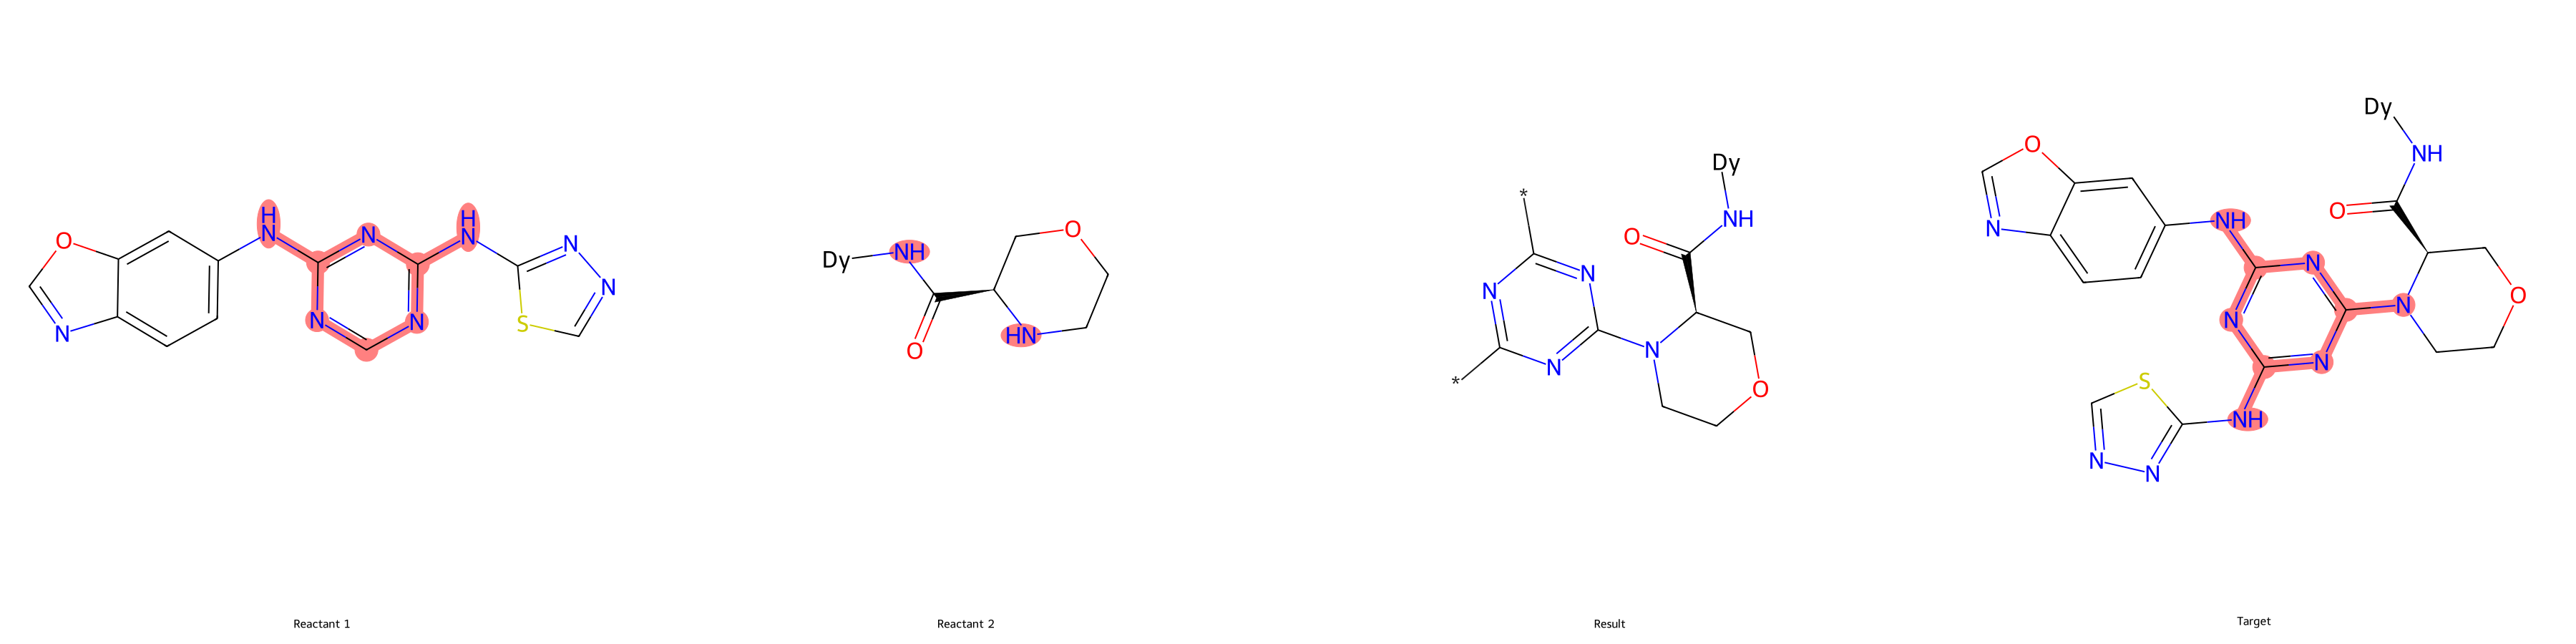

In [187]:
from rdkit import Chem
from rdkit.Chem import AllChem

# x = get_test_x_data()
x = get_train_x_data()
x.retrieval = DataRetrieval.SMILES

smiles = x[0]
mol = Chem.MolFromSmiles(smiles[0])
bb1 = Chem.MolFromSmiles(smiles[1])
bb2 = Chem.MolFromSmiles(smiles[2])
bb3 = Chem.MolFromSmiles(smiles[3])

# BB1: O=C(N[Dy])[C@H]1COCCN1
# Partial Result: c1nc(Nc2ccc3ncoc3c2)nc(Nc2nncs2)n1
# Result: O=C(N[Dy])[C@H]1COCCN1c1nc(Nc2ccc3ncoc3c2)nc(Nc2nncs2)n1

reactant_1_smile = "c1nc(Nc2ccc3ncoc3c2)nc(Nc2nncs2)n1"
reactant_1 = Chem.MolFromSmiles(reactant_1_smile)

reactant_2_smile = "O=C(N[Dy])[C@H]1COCCN1"
reactant_2 = Chem.MolFromSmiles(reactant_2_smile)

target_smile = "O=C(N[Dy])[C@H]1COCCN1c1nc(Nc2ccc3ncoc3c2)nc(Nc2nncs2)n1"
target = Chem.MolFromSmiles(target_smile)

# reaction_smarts = "c1n[c:1]ncn1.C[NH:2]C>>c1n[c:1](C[N:2])ncn1"
reaction_smarts = "[cH:1]1nc(*)nc(*)n1.[Nh:2]>>c(*)1nc(*)n[c:1]([N:2])n1"   # Jasper
reaction_smarts_1 = reaction_smarts.split(">>")[0].split(".")[0]
reaction_smarts_2 = reaction_smarts.split(">>")[0].split(".")[1]
reaction_smarts_product = reaction_smarts.split(">>")[1]

# test_mol = Chem.MolFromSmiles("c1n[c:1](C[N:2])ncn1")
# display(Draw.MolToImage(test_mol, size=(600, 600)))

try:
    reaction = AllChem.ReactionFromSmarts(reaction_smarts)
    reaction_products = reaction.RunReactants((reactant_1, reactant_2))
    print(f"Reaction Successful: {len(reaction_products)}")
    reaction_result = reaction_products[3][0]
    # for resaction_product in reaction_products:
    #     try:
    #         Chem.rdmolops.SanitizeMol(resaction_product)
    #         reaction_result = resaction_product[0]
    #     except Exception as e:
    #         print(f"Sanitize Failed: {e}")
    # display(Draw.MolsToGridImage([reactant_1, reactant_2, reaction_result], subImgSize=(900, 900), molsPerRow=3))
except Exception as e:
    print(f"Reaction Failed: {e}")
    reaction_result = Chem.MolFromSmiles("")

reactant_1_highlight = list(reactant_1.GetSubstructMatches(Chem.MolFromSmarts(reaction_smarts_1)))
reactant_1_highlight = set([item for sublist in reactant_1_highlight for item in sublist])
reactant_2_highlight = list(reactant_2.GetSubstructMatches(Chem.MolFromSmarts(reaction_smarts_2)))
reactant_2_highlight = set([item for sublist in reactant_2_highlight for item in sublist])
product_highlight = list(target.GetSubstructMatches(Chem.MolFromSmarts(reaction_smarts_product)))
product_highlight = set([item for sublist in product_highlight for item in sublist])

image = Draw.MolsToGridImage([reactant_1, reactant_2, reaction_result, target], molsPerRow=4, subImgSize=(900,900), highlightAtomLists=[reactant_1_highlight, reactant_2_highlight, [], product_highlight], legends=["Reactant 1", "Reactant 2", "Result", "Target"])
display(image)

## Create a General Algorithm to Create the Final Molecule out of the Building Blocks

In [11]:
from rdkit import Chem
from rdkit.Chem import AllChem
from tqdm import tqdm

def react_with_triazine(bb1_smiles: str, bb2_smiles: str, bb3_smiles: str, verbose: bool = False) -> str | None:
    bb1 = Chem.MolFromSmiles(bb1_smiles)
    bb2 = Chem.MolFromSmiles(bb2_smiles)
    bb3 = Chem.MolFromSmiles(bb3_smiles)

    # Setup reaction with Triazine
    triazine = Chem.MolFromSmiles("C1=NC=NC=N1")
    reaction_smarts = '[cH:1].[NH2:2]>>[c:1][NH:2]'
    reaction = AllChem.ReactionFromSmarts(reaction_smarts)

    # Reaction with BB2
    reaction_products = reaction.RunReactants((triazine, bb2))
    if len(reaction_products) == 0:
        print("Attaching BB2 failed") if verbose else None
        return None
    mol_reconstructed = Chem.RemoveHs(reaction_products[0][0])

    # Reaction with BB3
    reaction_products = reaction.RunReactants((mol_reconstructed, bb3))
    if len(reaction_products) == 0:
        print("Attaching BB3 failed") if verbose else None
        return None
    mol_reconstructed = Chem.RemoveHs(reaction_products[0][0])

    # Clean bb1
    common_substructure1 = Chem.MolFromSmiles('O=COCC1c2ccccc2-c2ccccc21') # Fmoc
    common_substructure2 = Chem.MolFromSmiles('CC(C)(C)OC(=O)') # Boc
    if bb1.HasSubstructMatch(common_substructure1) or bb1.HasSubstructMatch(common_substructure2):
        bb1 = Chem.rdmolops.DeleteSubstructs(bb1, common_substructure1, onlyFrags=False)
        bb1 = Chem.rdmolops.DeleteSubstructs(bb1, common_substructure2, onlyFrags=False)
    else:
        print("BB1 has no common substructure to remove") if verbose else None
        return None

    # Attach DNA to BB1
    dna = Chem.MolFromSmiles("N[Dy]")
    dna_reaction = AllChem.ReactionFromSmarts("[C:1][OH].[H2N:3]>>[C:1][NH:3]")
    bb1 = dna_reaction.RunReactants((bb1, dna))
    if len(bb1) == 0:
        print("Attaching DNA to BB1 failed") if verbose else None
        return None
    bb1 = Chem.RemoveHs(bb1[0][0])

    # Reaction with BB1
    reaction_products = reaction.RunReactants((mol_reconstructed, bb1))
    if len(reaction_products) == 0:
        print("Attaching BB1 failed") if verbose else None
        return None
    mol_reconstructed = Chem.RemoveHs(reaction_products[0][0])

    return Chem.MolToSmiles(mol_reconstructed)

# Test the function
# x = get_test_x_data()
x = get_train_x_data()
x.retrieval = DataRetrieval.SMILES

randomized_indices = np.random.choice(len(x), len(x), replace=False)

failed_ids = []
for idx in tqdm(randomized_indices):
    smiles = x[idx]
    mol = Chem.MolFromSmiles(smiles[0])
    bb1 = Chem.MolFromSmiles(smiles[1])
    bb2 = Chem.MolFromSmiles(smiles[2])
    bb3 = Chem.MolFromSmiles(smiles[3])

    reconstructed_mol = react_with_triazine(smiles[1], smiles[2], smiles[3])
    if reconstructed_mol is None:
        failed_ids.append(idx)
        print(f"Failed to reconstruct molecule with idx {idx}")
        break
        # continue

    reconstruction_successful = Chem.CanonSmiles(Chem.MolToSmiles(mol)) == Chem.CanonSmiles(reconstructed_mol)
    if not reconstruction_successful:
        print(f"Failed to reconstruct molecule with idx {idx}")
        failed_ids.append(idx)
        break
        
    # print(Chem.CanonSmiles(Chem.MolToSmiles(mol)) == Chem.CanonSmiles(reconstructed_mol))
    # display(Draw.MolsToGridImage([mol, Chem.MolFromSmiles(reconstructed_mol)], molsPerRow=2, subImgSize=(600, 600), legends=["Molecule", "Reconstructed Molecule"]))

  0%|          | 145/98415610 [00:00<37:50:52, 722.30it/s]

Failed to reconstruct molecule with idx 97288617
Failed to reconstruct molecule with idx 4088084
Failed to reconstruct molecule with idx 94241435
Failed to reconstruct molecule with idx 97041789
Failed to reconstruct molecule with idx 94898404
Failed to reconstruct molecule with idx 97294482
Failed to reconstruct molecule with idx 77583239
Failed to reconstruct molecule with idx 94343444
Failed to reconstruct molecule with idx 96195018
Failed to reconstruct molecule with idx 78650286
Failed to reconstruct molecule with idx 77955580
Failed to reconstruct molecule with idx 92213743
Failed to reconstruct molecule with idx 4475621
Failed to reconstruct molecule with idx 96376595
Failed to reconstruct molecule with idx 96471884
Failed to reconstruct molecule with idx 94532307
Failed to reconstruct molecule with idx 4029957
Failed to reconstruct molecule with idx 8633019
Failed to reconstruct molecule with idx 92013777
Failed to reconstruct molecule with idx 87166200


  0%|          | 291/98415610 [00:00<38:26:30, 711.14it/s]

Failed to reconstruct molecule with idx 8539948
Failed to reconstruct molecule with idx 97776504
Failed to reconstruct molecule with idx 95011475
Failed to reconstruct molecule with idx 97481969
Failed to reconstruct molecule with idx 5044609
Failed to reconstruct molecule with idx 93734458
Failed to reconstruct molecule with idx 92457167
Failed to reconstruct molecule with idx 96412920
Failed to reconstruct molecule with idx 97969556
Failed to reconstruct molecule with idx 77852190
Failed to reconstruct molecule with idx 78001997
Failed to reconstruct molecule with idx 78529795
Failed to reconstruct molecule with idx 94701383
Failed to reconstruct molecule with idx 96867569
Failed to reconstruct molecule with idx 4855777
Failed to reconstruct molecule with idx 93249091
Failed to reconstruct molecule with idx 10047103


  0%|          | 436/98415610 [00:00<38:41:59, 706.40it/s]

Failed to reconstruct molecule with idx 78693005
Failed to reconstruct molecule with idx 94957999
Failed to reconstruct molecule with idx 98015218
Failed to reconstruct molecule with idx 80410610
Failed to reconstruct molecule with idx 94862855
Failed to reconstruct molecule with idx 94129018
Failed to reconstruct molecule with idx 77391651
Failed to reconstruct molecule with idx 4579469
Failed to reconstruct molecule with idx 4842219
Failed to reconstruct molecule with idx 96394280
Failed to reconstruct molecule with idx 94316880
Failed to reconstruct molecule with idx 96625223
Failed to reconstruct molecule with idx 97267381


  0%|          | 579/98415610 [00:00<38:35:20, 708.43it/s]

Failed to reconstruct molecule with idx 97828423
Failed to reconstruct molecule with idx 97213318
Failed to reconstruct molecule with idx 10022668
Failed to reconstruct molecule with idx 78474060
Failed to reconstruct molecule with idx 96117833
Failed to reconstruct molecule with idx 5407804
Failed to reconstruct molecule with idx 5095364
Failed to reconstruct molecule with idx 96366563
Failed to reconstruct molecule with idx 93434521
Failed to reconstruct molecule with idx 97327588
Failed to reconstruct molecule with idx 94147453
Failed to reconstruct molecule with idx 95427532
Failed to reconstruct molecule with idx 80423825
Failed to reconstruct molecule with idx 97755949
Failed to reconstruct molecule with idx 95761689
Failed to reconstruct molecule with idx 94659062
Failed to reconstruct molecule with idx 95538436


  0%|          | 726/98415610 [00:01<37:50:48, 722.32it/s]

Failed to reconstruct molecule with idx 93302748
Failed to reconstruct molecule with idx 93012043
Failed to reconstruct molecule with idx 77538396
Failed to reconstruct molecule with idx 4556018
Failed to reconstruct molecule with idx 8592097
Failed to reconstruct molecule with idx 77605532
Failed to reconstruct molecule with idx 93976895
Failed to reconstruct molecule with idx 77465741
Failed to reconstruct molecule with idx 93709443
Failed to reconstruct molecule with idx 78731042
Failed to reconstruct molecule with idx 78085340
Failed to reconstruct molecule with idx 92413248
Failed to reconstruct molecule with idx 98010072
Failed to reconstruct molecule with idx 78323493
Failed to reconstruct molecule with idx 78243228
Failed to reconstruct molecule with idx 77778992
Failed to reconstruct molecule with idx 78399397
Failed to reconstruct molecule with idx 94070848


  0%|          | 874/98415610 [00:01<37:38:06, 726.38it/s]

Failed to reconstruct molecule with idx 78181146
Failed to reconstruct molecule with idx 4194992
Failed to reconstruct molecule with idx 77920223
Failed to reconstruct molecule with idx 95079017
Failed to reconstruct molecule with idx 93522796
Failed to reconstruct molecule with idx 97347515
Failed to reconstruct molecule with idx 78789571
Failed to reconstruct molecule with idx 87292936
Failed to reconstruct molecule with idx 94463247
Failed to reconstruct molecule with idx 80431934
Failed to reconstruct molecule with idx 92079161
Failed to reconstruct molecule with idx 91889172
Failed to reconstruct molecule with idx 78069619
Failed to reconstruct molecule with idx 87359572
Failed to reconstruct molecule with idx 4414055
Failed to reconstruct molecule with idx 97829493


  0%|          | 1019/98415610 [00:01<38:23:49, 711.97it/s]

Failed to reconstruct molecule with idx 78098660
Failed to reconstruct molecule with idx 4707842
Failed to reconstruct molecule with idx 94206380
Failed to reconstruct molecule with idx 4033240
Failed to reconstruct molecule with idx 92086170
Failed to reconstruct molecule with idx 4680786
Failed to reconstruct molecule with idx 4225293
Failed to reconstruct molecule with idx 95136825
Failed to reconstruct molecule with idx 91926162
Failed to reconstruct molecule with idx 78219040
Failed to reconstruct molecule with idx 96215009
Failed to reconstruct molecule with idx 93814732
Failed to reconstruct molecule with idx 93205932
Failed to reconstruct molecule with idx 8502189


  0%|          | 1163/98415610 [00:01<38:32:46, 709.21it/s]

Failed to reconstruct molecule with idx 4231185
Failed to reconstruct molecule with idx 9944570
Failed to reconstruct molecule with idx 10034933
Failed to reconstruct molecule with idx 87451032
Failed to reconstruct molecule with idx 80288366
Failed to reconstruct molecule with idx 15122503
Failed to reconstruct molecule with idx 95855264
Failed to reconstruct molecule with idx 8646775
Failed to reconstruct molecule with idx 8528918
Failed to reconstruct molecule with idx 94221866
Failed to reconstruct molecule with idx 93929072
Failed to reconstruct molecule with idx 78269295
Failed to reconstruct molecule with idx 97272540
Failed to reconstruct molecule with idx 97631629
Failed to reconstruct molecule with idx 9871330
Failed to reconstruct molecule with idx 77781264
Failed to reconstruct molecule with idx 94510026
Failed to reconstruct molecule with idx 77714470
Failed to reconstruct molecule with idx 94128929


  0%|          | 1310/98415610 [00:01<37:57:09, 720.30it/s]

Failed to reconstruct molecule with idx 95864392
Failed to reconstruct molecule with idx 77599221
Failed to reconstruct molecule with idx 93349604
Failed to reconstruct molecule with idx 95597847
Failed to reconstruct molecule with idx 80331596
Failed to reconstruct molecule with idx 93851015
Failed to reconstruct molecule with idx 92187731
Failed to reconstruct molecule with idx 94395578
Failed to reconstruct molecule with idx 77365131
Failed to reconstruct molecule with idx 97485330
Failed to reconstruct molecule with idx 95128626
Failed to reconstruct molecule with idx 94649700
Failed to reconstruct molecule with idx 96740440
Failed to reconstruct molecule with idx 93785794


  0%|          | 1455/98415610 [00:02<38:32:54, 709.16it/s]

Failed to reconstruct molecule with idx 95758528
Failed to reconstruct molecule with idx 94299625
Failed to reconstruct molecule with idx 95794913
Failed to reconstruct molecule with idx 97769995
Failed to reconstruct molecule with idx 78534616
Failed to reconstruct molecule with idx 80604274
Failed to reconstruct molecule with idx 77606954
Failed to reconstruct molecule with idx 93632015
Failed to reconstruct molecule with idx 93921224
Failed to reconstruct molecule with idx 94601922
Failed to reconstruct molecule with idx 78024780
Failed to reconstruct molecule with idx 92195668
Failed to reconstruct molecule with idx 77625145


  0%|          | 1674/98415610 [00:02<38:02:21, 718.66it/s]

Failed to reconstruct molecule with idx 96302851
Failed to reconstruct molecule with idx 87496240
Failed to reconstruct molecule with idx 97974701
Failed to reconstruct molecule with idx 15190325
Failed to reconstruct molecule with idx 95544437
Failed to reconstruct molecule with idx 94694234
Failed to reconstruct molecule with idx 96822335
Failed to reconstruct molecule with idx 80274793
Failed to reconstruct molecule with idx 96625845
Failed to reconstruct molecule with idx 92398587
Failed to reconstruct molecule with idx 5107918
Failed to reconstruct molecule with idx 78698951
Failed to reconstruct molecule with idx 4147424
Failed to reconstruct molecule with idx 77797421
Failed to reconstruct molecule with idx 96277728


  0%|          | 1821/98415610 [00:02<37:54:41, 721.08it/s]

Failed to reconstruct molecule with idx 93207270
Failed to reconstruct molecule with idx 93444972
Failed to reconstruct molecule with idx 93621434
Failed to reconstruct molecule with idx 95358459
Failed to reconstruct molecule with idx 77706956
Failed to reconstruct molecule with idx 93403895
Failed to reconstruct molecule with idx 77857232
Failed to reconstruct molecule with idx 92557157
Failed to reconstruct molecule with idx 94272429
Failed to reconstruct molecule with idx 94471539
Failed to reconstruct molecule with idx 95580296
Failed to reconstruct molecule with idx 97551495
Failed to reconstruct molecule with idx 96026219
Failed to reconstruct molecule with idx 92593966
Failed to reconstruct molecule with idx 96931778


  0%|          | 1968/98415610 [00:02<37:44:37, 724.28it/s]

Failed to reconstruct molecule with idx 8352810
Failed to reconstruct molecule with idx 5433547
Failed to reconstruct molecule with idx 8677446
Failed to reconstruct molecule with idx 92429824
Failed to reconstruct molecule with idx 96711532
Failed to reconstruct molecule with idx 95389130
Failed to reconstruct molecule with idx 77731458
Failed to reconstruct molecule with idx 95616385
Failed to reconstruct molecule with idx 77593381
Failed to reconstruct molecule with idx 97280004
Failed to reconstruct molecule with idx 78433419
Failed to reconstruct molecule with idx 96973390
Failed to reconstruct molecule with idx 4037617
Failed to reconstruct molecule with idx 95294722
Failed to reconstruct molecule with idx 92316902
Failed to reconstruct molecule with idx 94264332
Failed to reconstruct molecule with idx 15052169
Failed to reconstruct molecule with idx 97062271
Failed to reconstruct molecule with idx 94134352


  0%|          | 2051/98415610 [00:02<38:08:23, 716.76it/s]

Failed to reconstruct molecule with idx 87346632
Failed to reconstruct molecule with idx 8376803
Failed to reconstruct molecule with idx 5141355
Failed to reconstruct molecule with idx 93322016
Failed to reconstruct molecule with idx 96017153
Failed to reconstruct molecule with idx 94933489


KeyboardInterrupt: 

## Find Cores
Building Block 1 is the core in the test set...

Tested chunks: 32863/878022


  6%|▋         | 54060/845159 [00:05<01:23, 9476.41it/s]

Idx: 86997
Unknown core in smiles: ['CC(=O)Nc1cccc(C(=O)N2CCC(Oc3cc(C(=O)N[Dy])ccc3C=C(C)c3ccnn3C)CC2)c1'
 'CC(C)(C)OC(=O)N1CCC(Oc2cc(C(=O)O)ccc2I)CC1'
 'C/C(=C\\B1OC(C)(C)C(C)(C)O1)c1ccnn1C' 'CC(=O)Nc1cccc(C(=O)O)c1']


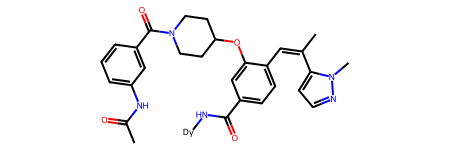

  6%|▋         | 54134/845159 [00:05<01:24, 9359.11it/s]


In [ ]:
from rdkit import Chem
from tqdm import tqdm

x = get_test_x_data()
x.retrieval = DataRetrieval.SMILES
smiles_array = x[:]

known_cores = [
    Chem.MolFromSmiles("C1=NC=NC=N1"),  # Triazine
    Chem.MolFromSmiles("N1CC(c2ccccc2)=C[C@H]1C"),
    Chem.MolFromSmiles("N1CCC(c2ccccc2)CC1"),
    Chem.MolFromSmiles("N1CCC(COc2ccccc2)CC1"),
]
exception_indices = []


tested_smiles = 86997
print(f'Tested chunks: {tested_smiles}/{len(smiles_array)}')
for idx, smiles in tqdm(enumerate(smiles_array[tested_smiles:]), total=len(smiles_array[tested_smiles:])):
    if idx in exception_indices:
        continue
    mol = Chem.MolFromSmiles(smiles[0])
    if all([mol.HasSubstructMatch(core) == False for core in known_cores]):
        print(f"Idx: {tested_smiles + idx}")
        print(f"Unknown core in smiles: {smiles}")
        display(mol)
        break


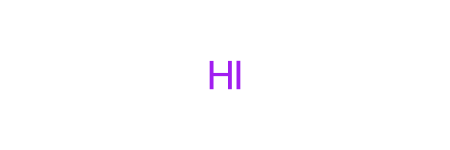

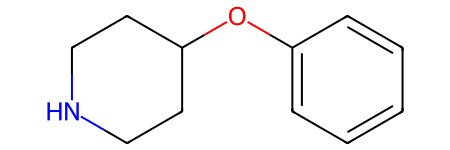

Smile Molecule: ['CC(=O)c1ncc(C(=O)N2CCC(Oc3cc(C(=O)N[Dy])ccc3C=C(C)c3ccnn3C)CC2)s1'
 'CC(C)(C)OC(=O)N1CCC(Oc2cc(C(=O)O)ccc2I)CC1'
 'C/C(=C\\B1OC(C)(C)C(C)(C)O1)c1ccnn1C' 'CC(=O)c1ncc(C(=O)O)s1']


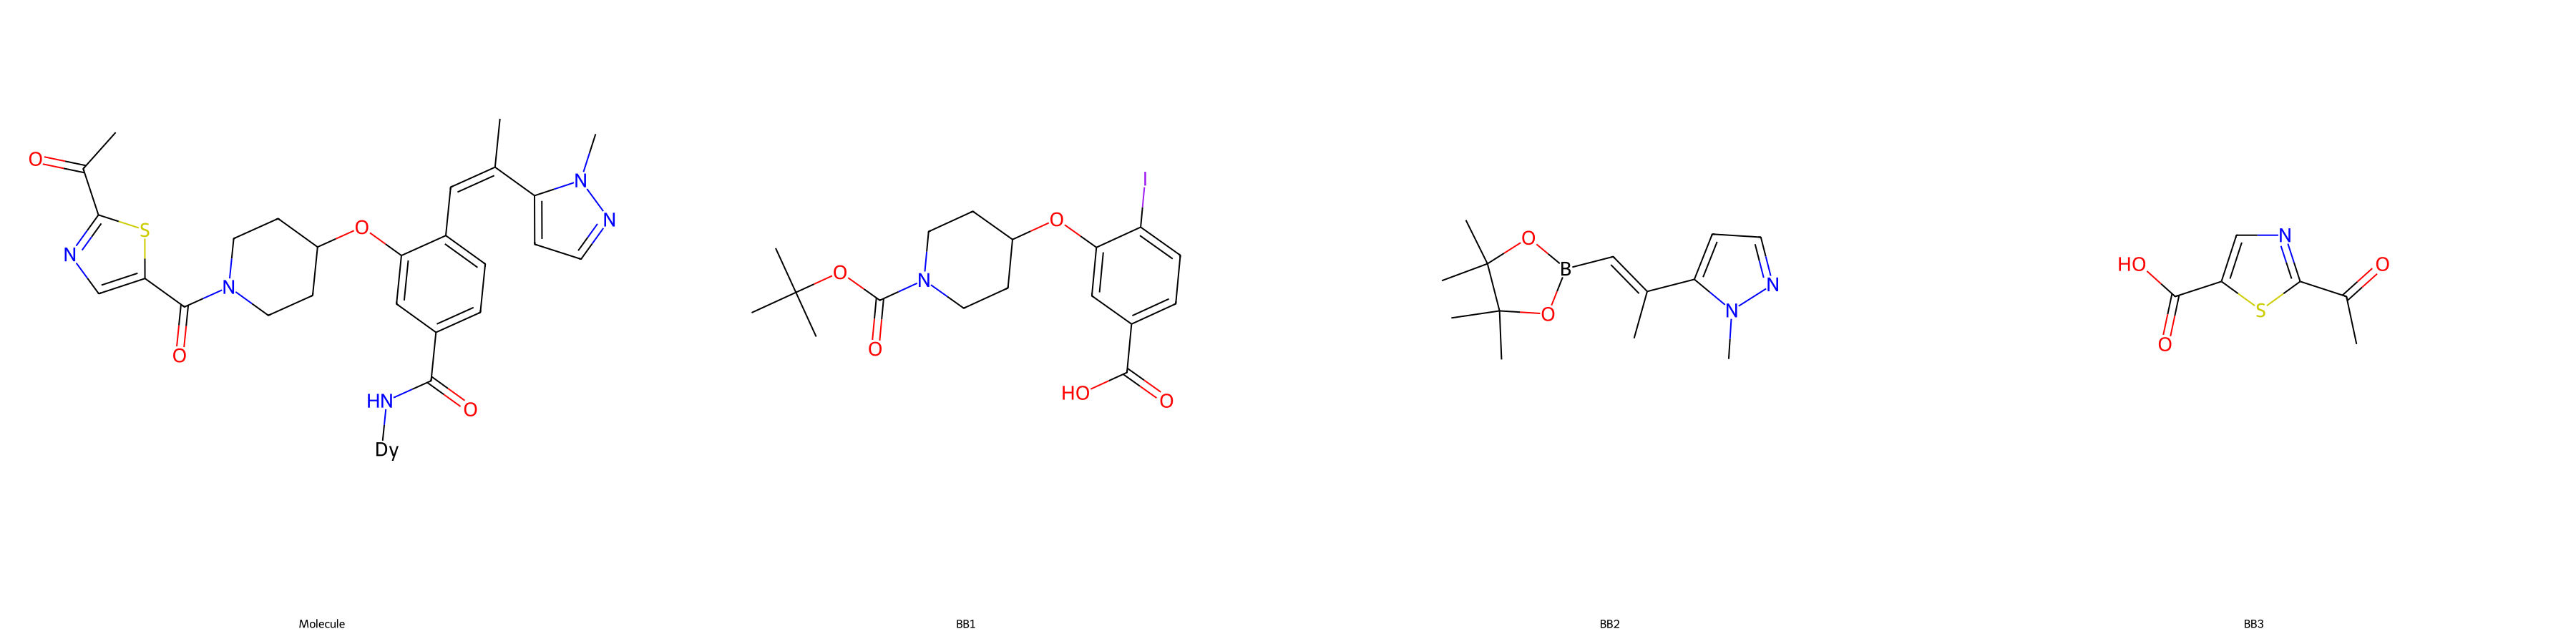

In [ ]:
indecies = [86998]

for idx in indecies:
    mol = Chem.MolFromSmiles(smiles_array[idx][0])
    bb1 = Chem.MolFromSmiles(smiles_array[idx][1])
    bb2 = Chem.MolFromSmiles(smiles_array[idx][2])
    bb3 = Chem.MolFromSmiles(smiles_array[idx][3])

    highlight_atoms = []
    try:
        test_core = Chem.MolFromSmiles("c2ccccc2")
        test_core = Chem.MolFromSmiles("N1CCCCC1")
        test_core = Chem.MolFromSmiles("N1CCC(COc2ccccc2)CC1")
        # display(test_core)
        # mol_1 = Chem.rdmolops.DeleteSubstructs(bb1, Chem.MolFromSmiles("I"))
        # mol_1 = Chem.rdmolops.DeleteSubstructs(mol_1, Chem.MolFromSmiles("CC(C)(C)OC(=O)"))
        # mol_1 = Chem.rdmolops.DeleteSubstructs(mol_1, Chem.MolFromSmiles("C(=O)O"))
        # display(mol_1)

        substruct_match = mol.GetSubstructMatch(test_core)
        highlight_atoms = list(substruct_match)
    except:
        pass

    print(f"Smile Molecule: {smiles_array[idx]}")
    image = Draw.MolsToGridImage([mol, bb1, bb2, bb3], molsPerRow=4, subImgSize=(900, 900), legends=["Molecule", "BB1", "BB2", "BB3"], highlightAtomLists=[highlight_atoms, [], [], []])
    display(image)